### Detection

#### Baseline-1
After doing a literature survey of identifying real v/s generated text, we figured out that OpenAi has already worked upon similar problem of identifying gpt-2 output dataset from real world texts.
Their best performing model was a finetuned roberta on webtext data. As a very first baseline we tried using their pretrained model on our validation dataset.    
[Source](https://d4mucfpksywv.cloudfront.net/papers/GPT_2_Report.pdf)
##### Classification Report


#### Baseline-2
We wanted to try out a very simple baseline to compare results. Tried out Naive Bayes with Logitic Regression as another baseline.   
[Source](https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf)

###### Classification Report

#### Final Model
Inspired from the very same idea by OpenAi of finetuning RoBERTa, we decided to finetune RoBERTa on our dataset consisting of real reviews from Amazon dataset against our Generated reviews from Finetuned GPT-2 in the phase-1 of the project.
Idea being RoBERTa is a masked and non-generative language model that does not share the same architecture or the same tokenizer as GPT-2.   

The RoBERTa model was proposed in [RoBERTa: A Robustly Optimized BERT Pretraining Approach](https://arxiv.org/abs/1907.11692) by Yinhan Liu, Myle Ott, Naman Goyal, Jingfei Du, Mandar Joshi, Danqi Chen, Omer Levy, Mike Lewis, Luke Zettlemoyer, Veselin Stoyanov. It is based on Google’s BERT model released in 2018.
It builds on BERT and modifies key hyperparameters, removing the next-sentence pretraining objective and training with much larger mini-batches and learning rates.
[Source](https://huggingface.co/transformers/model_doc/roberta.html)

##### Classification Report

### Analysis

Post analysis of our above three models against different categories of Amazon Reviews is added below:

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import pandas as pd

In [8]:
df = pd.read_csv("../../data/classification/data/data.csv")

In [9]:
encoded_label_dict = {"CG" : 0, "OR" : 1}
def encode_label(x):
    return encoded_label_dict.get(x,-1)

In [10]:
df["target"] = df["label"].apply(lambda x: encode_label(x))

In [11]:
train_df, valid_df = train_test_split(df, test_size=0.2, shuffle=True, stratify=None, random_state=2021)

In [16]:
df1 = pd.read_csv("../../data/classification/data/gpt2_detector_predictions.csv")
df2 = pd.read_csv("../../data/classification/data/ft_roberta_predictions.csv")
df3 = pd.read_csv("../../data/classification/data/NbLogReg_predictions.csv")

In [19]:
merged_df = pd.concat([valid_df.reset_index(drop=True), df1.reset_index(drop=True), df2.reset_index(drop=True), df3.reset_index(drop=True)], axis= 1)

In [20]:
merged_df.head()

,category,rating,label,text_,target,GPT2_Detector_Model_Probability,GPT2_Detector_Model_Prediction,Finetune_Roberta_Model_Probability,Finetune_Roberta_Model_Prediction,NbLogReg_Model_Probability,NbLogReg_Model_Prediction
0,Electronics_5,4.0,CG,I bought this cover for my wife and she loves ...,0,0.005580,0,0.032347,0,0.000938,0
1,Pet_Supplies_5,5.0,CG,I have been giving this to my dog for about a ...,0,0.000172,0,0.013948,0,0.002291,0
2,Tools_and_Home_Improvement_5,4.0,OR,"All as described, and should be for what it is...",1,0.321705,0,0.902460,1,0.921376,1
3,Books_5,5.0,OR,"This isn't a just a zombie SAW-like story, but...",1,0.002924,0,0.999647,1,0.992723,1
4,Books_5,3.0,OR,This historical thriller revolves around the E...,1,0.999816,1,0.999547,1,0.990737,1


In [ ]:
merged_df.to_csv("../../data/classification/data/MergedPredictions.csv",index=None)

In [49]:
merged_df["gpt2_matched"] = merged_df["target"] == merged_df["GPT2_Detector_Model_Prediction"]
merged_df["roberta_matched"] = merged_df["target"] == merged_df["Finetune_Roberta_Model_Prediction"]
merged_df["nb_matched"] = merged_df["target"] == merged_df["NbLogReg_Model_Prediction"]

In [70]:
gpt2_category_acc = merged_df.groupby("category")["gpt2_matched"].mean()*100

In [71]:
roberta_category_acc = merged_df.groupby("category")["roberta_matched"].mean()*100

In [72]:
nb_category_acc = merged_df.groupby("category")["nb_matched"].mean()*100

Text(0.5, 1.0, 'Accuracies across categories for NBLogisticRegression')

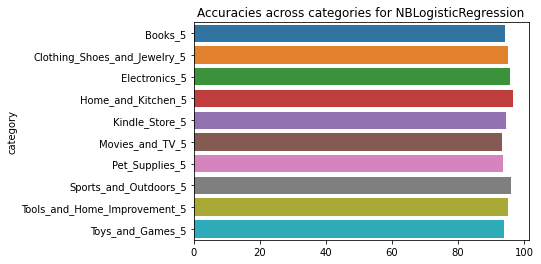

In [73]:
sns.barplot(x=nb_category_acc.values,y=nb_category_acc.index)
plt.title("Accuracies across categories for NBLogisticRegression")

Text(0.5, 1.0, 'Accuracies across categories for GPT2-OutputDetector')

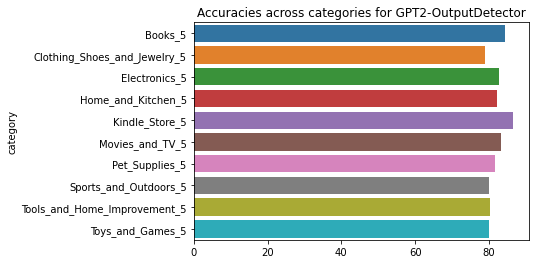

In [74]:
sns.barplot(x=gpt2_category_acc.values,y=gpt2_category_acc.index)
plt.title("Accuracies across categories for GPT2-OutputDetector")
# plt.yticks(rotation=45)

Text(0.5, 1.0, 'Accuracies across categories for Finetuned Roberta')

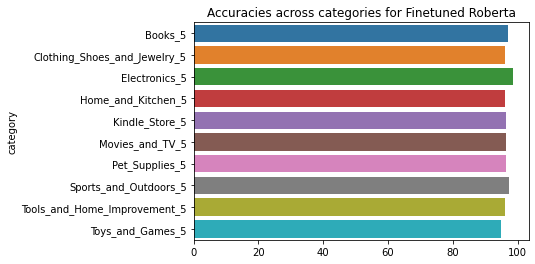

In [75]:
sns.barplot(x=roberta_category_acc.values,y=roberta_category_acc.index)
plt.title("Accuracies across categories for Finetuned Roberta")
# plt.yticks(rotation=45)